<a href="https://colab.research.google.com/github/alirezash97/Cardio/blob/master/Cardio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

!pip3 install git+https://github.com/analysiscenter/cardio.git

  Cloning https://github.com/analysiscenter/cardio.git to /tmp/pip-req-build-jag61vfd
  Running command git clone -q https://github.com/analysiscenter/cardio.git /tmp/pip-req-build-jag61vfd
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 12.4MB 339kB/s 
     |████████████████████████████████| 35.3MB 88kB/s 
     |████████████████████████████████| 1.1MB 44.7MB/s 
     |████████████████████████████████| 102kB 12.7MB/s 
     |████████████████████████████████| 194kB 40.9MB/s 
     |████████████████████████████████| 163kB 39.1MB/s 
  Created wheel for cardio: filename=cardio-0.3.0-cp36-none-any.whl size=248078 sha256=7d4b94ce8c250f416a1f725f80a67bdc5d64b4a982d8f31c603008c60dfb6d31
  Stored in directory: /tmp/pip-ephem-wheel-cache-febu97q1/wheels/4c/29/94/e3046a28c95e8529c92d4b1563d248ecc3736988ac1ddbd624
  Created wheel for pyedflib: filename=pyEDFlib-0.1.17-cp36-cp36m-linux_x86_64.whl size=920789 sha256=3772b17439699dd9f01cbd40df6500943f

In [0]:
import cardio
import wfdb
import tensorflow as tf

In [0]:
!unzip '/content/drive/My Drive/Cardio/training2017.zip'

In [0]:
########## traingng 2017 ########
import sys
import numpy as np

from matplotlib import pyplot as plt

sys.path.append('/content/training2017')

import cardio.batchflow as bf
index = bf.FilesIndex(path='/content/training2017/A*.hea', no_ext=True, sort=True)

In [6]:
print(index.indices)

['A00001' 'A00002' 'A00003' ... 'A08526' 'A08527' 'A08528']


In [0]:
from cardio import EcgBatch
eds = bf.Dataset(index, batch_class=EcgBatch)

In [0]:
from cardio import EcgDataset
eds = EcgDataset(path='/content/training2017/*.hea', no_ext=True, sort=True)

In [0]:
batch = eds.next_batch(batch_size=8528, unique_labels=['A', 'N', 'O', '~'])

In [0]:
batch_with_data = batch.load(fmt='wfdb', components=['signal', 'meta'])

In [0]:
batch_with_data = batch_with_data.load(src='/content/training2017/REFERENCE.csv', fmt='csv', components='target')

In [59]:
print(batch_with_data['A04211'].signal.shape)
print(batch_with_data['A04211'].target)
print(batch_with_data['A04211'].signal)

(1, 18000)
N
[[-0.497 -0.633 -0.775 ... -0.01  -0.028 -0.04 ]]


In [60]:
import random

Augmented = 0
dataset = np.zeros((15000, 9001))
pointer = 0
for ecg in batch_with_data:
  
  if ecg.target == 'A' or ecg.target == 'O' or ecg.target == 'N' or ecg.target == '~' : 
    if ecg.signal.shape[1] == 18000:
        
        dataset[pointer:pointer+1, :9000] = ecg.signal[:1, :9000]

        ### pointer+2 for next slice ###

        if ecg.target == 'A':
          dataset[pointer:pointer+2, 9000:9001] = 0
        elif ecg.target == 'N':
          dataset[pointer:pointer+2, 9000:9001] = 1
        elif ecg.target == 'O':
          dataset[pointer:pointer+2, 9000:9001] = 2
        elif ecg.target == '~':
          dataset[pointer:pointer+2, 9000:9001] = 3
        
        pointer += 1 
          
        ###### next slice ######

        
        dataset[pointer:pointer+1, :9000] = ecg.signal[:1, 9000:18000]
        pointer += 1 
        
        ## target column is already filled ##

    elif ecg.signal.shape[1] == 9000:
        
        dataset[pointer:pointer+1, :9000] = ecg.signal[:1, :9000]


        if ecg.target == 'A':
          dataset[pointer:pointer+1, 9000:9001] = 0
        elif ecg.target == 'N':
          dataset[pointer:pointer+1, 9000:9001] = 1
        elif ecg.target == 'O':
          dataset[pointer:pointer+1, 9000:9001] = 2
        elif ecg.target == '~':
          dataset[pointer:pointer+2, 9000:9001] = 3
        
        pointer += 1

    elif ecg.signal.shape[1] > 9000 and ecg.signal.shape[1] != 18000:
      
      
      dataset[pointer:pointer+1, :9000] = ecg.signal[:1, :9000]
      

      if ecg.target == 'A':
        dataset[pointer:pointer+1, 9000:9001] = 0
      elif ecg.target == 'N':
        dataset[pointer:pointer+1, 9000:9001] = 1
      elif ecg.target == 'O':
        dataset[pointer:pointer+1, 9000:9001] = 2
      elif ecg.target == '~':
        dataset[pointer:pointer+2, 9000:9001] = 3
        
        pointer += 1

    #### data augmentation ######


    if ecg.signal.shape[1] >= 9000:
      chance = 0.8
      rand_num = random.uniform(0, 1)
        
      if chance > rand_num :

          
        noise = np.random.normal(scale=0.05, size=9000)
        new_signal = ecg.signal[:1, :9000] + noise  
        dataset[pointer:pointer+1, :9000] = new_signal



        if ecg.target == 'A':
          dataset[pointer:pointer+1, 9000:9001] = 0
        elif ecg.target == 'N':
          dataset[pointer:pointer+1, 9000:9001] = 1
        elif ecg.target == 'O':
          dataset[pointer:pointer+1, 9000:9001] = 2
        elif ecg.target == '~':
          dataset[pointer:pointer+2, 9000:9001] = 3
        
        pointer += 1
        Augmented += 1

    ################################

    else: 
      pass

  else:
    pass



print(Augmented)

6080


In [75]:
dataset[13688:13691, :]

array([[-0.28575731, -0.27917286, -0.38586083, ..., -0.00832405,
        -0.0405368 ,  1.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [0]:

trainset = np.zeros((13688, 9001))
trainset = dataset[:13688, :]

# some of the signals are skipped because of different dimentions

[[-0.13623854 -0.19939531 -0.27000897 ...  0.11733596  0.07253349
   0.08176102]]
[[1.]]


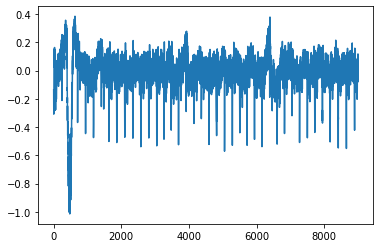

In [77]:
import matplotlib.pyplot as plt

# signal in trainset 
x = trainset[7000:7001, :-1]
target = trainset[7000:7001, -1:] 
plt.plot(x[0])
plt.show
print(x)
print(target)

In [0]:
temp = trainset[:, :]
temp = np.take(temp,np.random.permutation(temp.shape[0]),axis=0,out=temp);
X = temp[:, :-1]
Y = temp[:, -1:].reshape(13688, 1)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)


In [0]:
########  teeeeest ########## 
for index,row in enumerate(X_train):

  if row[0] == -0.497:
    print(row)
    print(y_train[index])


#############################

[-0.497 -0.633 -0.775 ... -0.016 -0.014 -0.011]
2.0


In [80]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (12319, 9000)
y_train (12319, 1)
X_test (1369, 9000)
y_test (1369, 1)


In [0]:
X_train = np.array(X_train.reshape(12319, 9000, 1))
X_test = np.array(X_test.reshape(1369, 9000, 1))
y_train = np.array(y_train)
y_test = np.array(y_test)

In [82]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (12319, 9000, 1)
y_train (12319, 1)
X_test (1369, 9000, 1)
y_test (1369, 1)


In [0]:
from keras.utils.np_utils import to_categorical


y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [84]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (12319, 9000, 1)
y_train (12319, 4)
X_test (1369, 9000, 1)
y_test (1369, 4)


In [0]:
# from scipy.sparse import csr_matrix
# y_train = csr_matrix.toarray(y_train)
# y_test = csr_matrix.toarray(y_test)

In [92]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model


# load model
model = load_model('/content/drive/My Drive/Cardio/HeartBeat.h5')

# summarize model.
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2999, 64)     384         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 2999, 64)     36928       conv1d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2999, 64)     256         conv1d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, Activation, Add, MaxPooling1D,
                                     Flatten, Dense, Softmax, LeakyReLU, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


In [94]:
X_input = model.layers[-8].output


# ######
# conv0 = Conv1D(filters=128, kernel_size= 9, strides = 2, padding='same')(X_input)
# # Bn0 = BatchNormalization()(conv0)
# Act0 = ReLU()(conv0)
# conv1 = Conv1D(filters=256, kernel_size= 7, strides = 2, padding='same')(Act0)
# # Bn1 = BatchNormalization()(conv1)
# Act1 = ReLU()(conv1)

# pool0=MaxPool1D(pool_size=(2), strides=(2), padding="same")(Act1)
# flatten=Flatten()(pool0)


Flat1 = Flatten()(X_input)

D0 = Dense(256, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(Flat1)
Bn2 = BatchNormalization(name= 'batchNorm0')(D0)
Act2 = LeakyReLU(name='leaky_re_lu1')(Bn2)
Drop0 = Dropout(0.5)(Act2)
######

D1 = Dense(128, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(Drop0)
# AP1 = GlobalAveragePooling2D()(D1)
Bn3 = BatchNormalization(name= 'batchNorm1')(D1)
Act3 = LeakyReLU(name='leaky_re_lu2')(Bn3)
Drop1 = Dropout(0.3)(Act3)

#####

D2 = Dense(64)(Drop1)
# AP1 = GlobalAveragePooling2D()(D1)
Bn4 = BatchNormalization(name= 'batchNorm2')(D2)
Act4 = LeakyReLU(name='leaky_re_lu3')(Bn4)
Drop2 = Dropout(0.1)(Act2)

#####
D3 = Dense(4)(Drop2)
Act5 = Softmax()(D3)

new_model = Model(inputs=model.inputs, outputs=Act5)
new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2999, 64)     384         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 2999, 64)     36928       conv1d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2999, 64)     256         conv1d_1[0][0]                   
____________________________________________________________________________________________

In [95]:
new_model.get_layer('conv1d').trainable = False
new_model.get_layer('conv1d_1').trainable = False
new_model.get_layer('batch_normalization').trainable = False
new_model.get_layer('conv1d_2').trainable = False
new_model.get_layer('batch_normalization_1').trainable = False
new_model.get_layer('conv1d_3').trainable = False
new_model.get_layer('batch_normalization_2').trainable = False
new_model.get_layer('batch_normalization_3').trainable = False
new_model.get_layer('conv1d_4').trainable = False
new_model.get_layer('batch_normalization_4').trainable = False
new_model.get_layer('conv1d_5').trainable = False
new_model.get_layer('batch_normalization_5').trainable = False
new_model.get_layer('conv1d_6').trainable = False
new_model.get_layer('batch_normalization_6').trainable = False
new_model.get_layer('conv1d_7').trainable = False
new_model.get_layer('batch_normalization_7').trainable = False
new_model.get_layer('batch_normalization_8').trainable = False
new_model.get_layer('conv1d_8').trainable = False
new_model.get_layer('batch_normalization_9').trainable = False
new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2999, 64)     384         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 2999, 64)     36928       conv1d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2999, 64)     256         conv1d_1[0][0]                   
____________________________________________________________________________________________

In [96]:
# compile model
new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early Stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Fit the model
new_model.fit(X_train, y_train, epochs=15, batch_size=256, validation_data=(X_test, y_test), callbacks=[es_callback])

Epoch 1/15
49/49 [==============================] - 373s 8s/step - loss: 1.8976 - accuracy: 0.5888 - val_loss: 1.8544 - val_accuracy: 0.6063
Epoch 2/15
49/49 [==============================] - 370s 8s/step - loss: 1.3528 - accuracy: 0.6583 - val_loss: 1.3999 - val_accuracy: 0.6165
Epoch 3/15
49/49 [==============================] - 372s 8s/step - loss: 1.1730 - accuracy: 0.6803 - val_loss: 1.2788 - val_accuracy: 0.6267
Epoch 4/15
49/49 [==============================] - 370s 8s/step - loss: 1.0866 - accuracy: 0.7052 - val_loss: 1.2055 - val_accuracy: 0.6384
Epoch 5/15
49/49 [==============================] - 370s 8s/step - loss: 1.0389 - accuracy: 0.7219 - val_loss: 1.1061 - val_accuracy: 0.6728
Epoch 6/15
49/49 [==============================] - 370s 8s/step - loss: 0.9968 - accuracy: 0.7369 - val_loss: 1.1521 - val_accuracy: 0.6654
Epoch 7/15
49/49 [==============================] - 371s 8s/step - loss: 1.0264 - accuracy: 0.7384 - val_loss: 1.1195 - val_accuracy: 0.6633
Epoch 8/15
49

KeyboardInterrupt: ignored

In [0]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# save model and architecture to single file
model.save('/content/drive/My Drive/Cardio/AF_Classification.h5')
print("Saved model to disk")

accuracy: 79.56%
Saved model to disk
